In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, learning_curve,\
train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier, Ridge, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.compose import make_column_selector

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display='diagram')

def_df = pd.read_csv("../raw_data/defaulter_data_13364.csv", index_col=[0])
pay_df = pd.read_csv("../raw_data/payer_data_41940.csv", index_col=[0])
def_df['default'] = 1
pay_df['default'] = 0

df = pd.concat([def_df, pay_df])

y = df['default']

X = df.drop(columns=['default'])


X_corr = X.corr()

X_corr = X_corr.unstack().reset_index() # Unstack correlation matrix 
X_corr.columns = ['feature_1','feature_2', 'correlation_all'] # rename columns
X_corr.sort_values(by="correlation_all",ascending=False, inplace=True) # sort by correlation
X_corr = X_corr[X_corr['feature_1'] != X_corr['feature_2']] # Remove self correlation
X_corr = X_corr.drop_duplicates(subset='correlation_all')

red_features = list(X_corr[abs(X_corr['correlation_all'])>=.95]['feature_1']) ## abs so we also consider the negative corrs

df = df.drop(columns=red_features) ## dropping the highly correlated columns




In [49]:
spend_vals=[col for col in df.columns if col.startswith('S') or col in ['customer_ID','default']]

In [50]:
df_spend=df.loc[:,spend_vals]

In [51]:
df_spend=df_spend.drop(columns=['S_2'])

In [52]:
df_spend.head()

customer_ID       S_3       S_5  \
0  6ba461c93869797c49b0f34c29274e50915466eda02a82...  0.301375  0.049738   
1  6ea315e6f219bc513964121907331f96e5b194127ebee3...  0.218091  0.415822   
2  6f105fec0ab833183a6a7aa3e39e79a6adf88a7cabe9df...  0.240602  0.009083   
3  6f105fec0ab833183a6a7aa3e39e79a6adf88a7cabe9df...  0.257985  0.008600   
4  6f105fec0ab833183a6a7aa3e39e79a6adf88a7cabe9df...  0.154248  0.007398   

        S_6       S_7       S_8       S_9      S_11      S_12      S_13  ...  \
0  0.000006  0.583665  0.472461       NaN  0.283972  0.191661  0.001828  ...   
1  0.001153  0.420417  0.491204  0.118886  0.202959  0.099092  0.422713  ...   
2  0.007712  0.216172  0.467482       NaN  0.401534  0.194208  0.007319  ...   
3  0.004203  0.225347  0.331234       NaN  0.448027  0.189468  0.003102  ...   
4  0.002049  0.097466  0.603705       NaN  0.401532  0.560308  0.282326  ...   

       S_17      S_18      S_19      S_20      S_22      S_23      S_25  \
0  0.008025  0.002588  0.003660  0.008439  0.989639  0.132125  0.973891   
1  0.004669  0.004642  0.000072  0.005597  1.001525  0.135112  0.979071   
2  0.001979  0.002801  0.003365  0.009713  0.927135  0.134301  0.975155   
3  0.004219  0.001601  0.008511  0.002836  0.798833  0.137929  0.975372   
4  0.000117  0.004432  0.002701  0.008896  0.891060  0.131264  0.974655   

       S_26      S_27  default  
0  0.003886  0.008533        1  
1  0.005253  0.570849        1  
2  0.008911  0.001540        1  
3  0.004241  0.009616        1  
4  0.001270  0.007735        1  

[5 rows x 22 columns]

In [55]:
df_spend_avg=df_spend.groupby('customer_ID').mean()
X_spend_avg=df_spend_avg.iloc[:,:-1]
y_avg=df_spend_avg.iloc[:,-1]

In [56]:
df_spend_avg.head()

S_3       S_5  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.200479  0.119229   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.150973  0.007212   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.174699  0.014250   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...       NaN  0.003034   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.265721  0.005382   

                                                         S_6       S_7  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.005275  0.545519   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.003970  0.450000   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.004965  0.174379   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  1.005308       NaN   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.928874  0.311663   

                                                         S_8       S_9  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.334238  0.008354   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.514540  0.006198   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.257859  0.003109   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  0.007306       NaN   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.029011       NaN   

                                                        S_11      S_12  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.435182  0.336190   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.398248  0.275876   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.222205  0.189568   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  0.286770  0.188584   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.292042  0.191192   

                                                        S_13      S_15  ...  \
customer_ID                                                             ...   
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.618137  0.396964  ...   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.127193  0.197590  ...   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.068504  0.358344  ...   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  0.004829  0.506315  ...   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.004923  0.482656  ...   

                                                        S_17      S_18  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.004429  0.005562   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.004832  0.004806   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.004159  0.004919   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  0.004522  0.005940   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.005082  0.004367   

                                                        S_19      S_20  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.003950  0.004941   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.005081  0.003623   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.004995  0.005459   
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f...  0.004659  0.005458   
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a52...  0.005769  0.004394   

                                                        S_22      S_23  \
customer_ID                                                              
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc058...  0.963832  0.435052   
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b7...  0.808178  0.135705   
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f...  0.950486  0.223182   
0044d8693a5c204d5e2

In [58]:
y_avg.head()

customer_ID
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc0583b60734da25265fb1    0.0
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b76a183afa0ae941c34    0.0
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f166dc2f2158513462    1.0
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f46abff9a163f78b3e    0.0
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a5282695654cee8af21f    1.0
Name: default, dtype: float64

In [59]:
X_spend_avg.shape

(4575, 20)

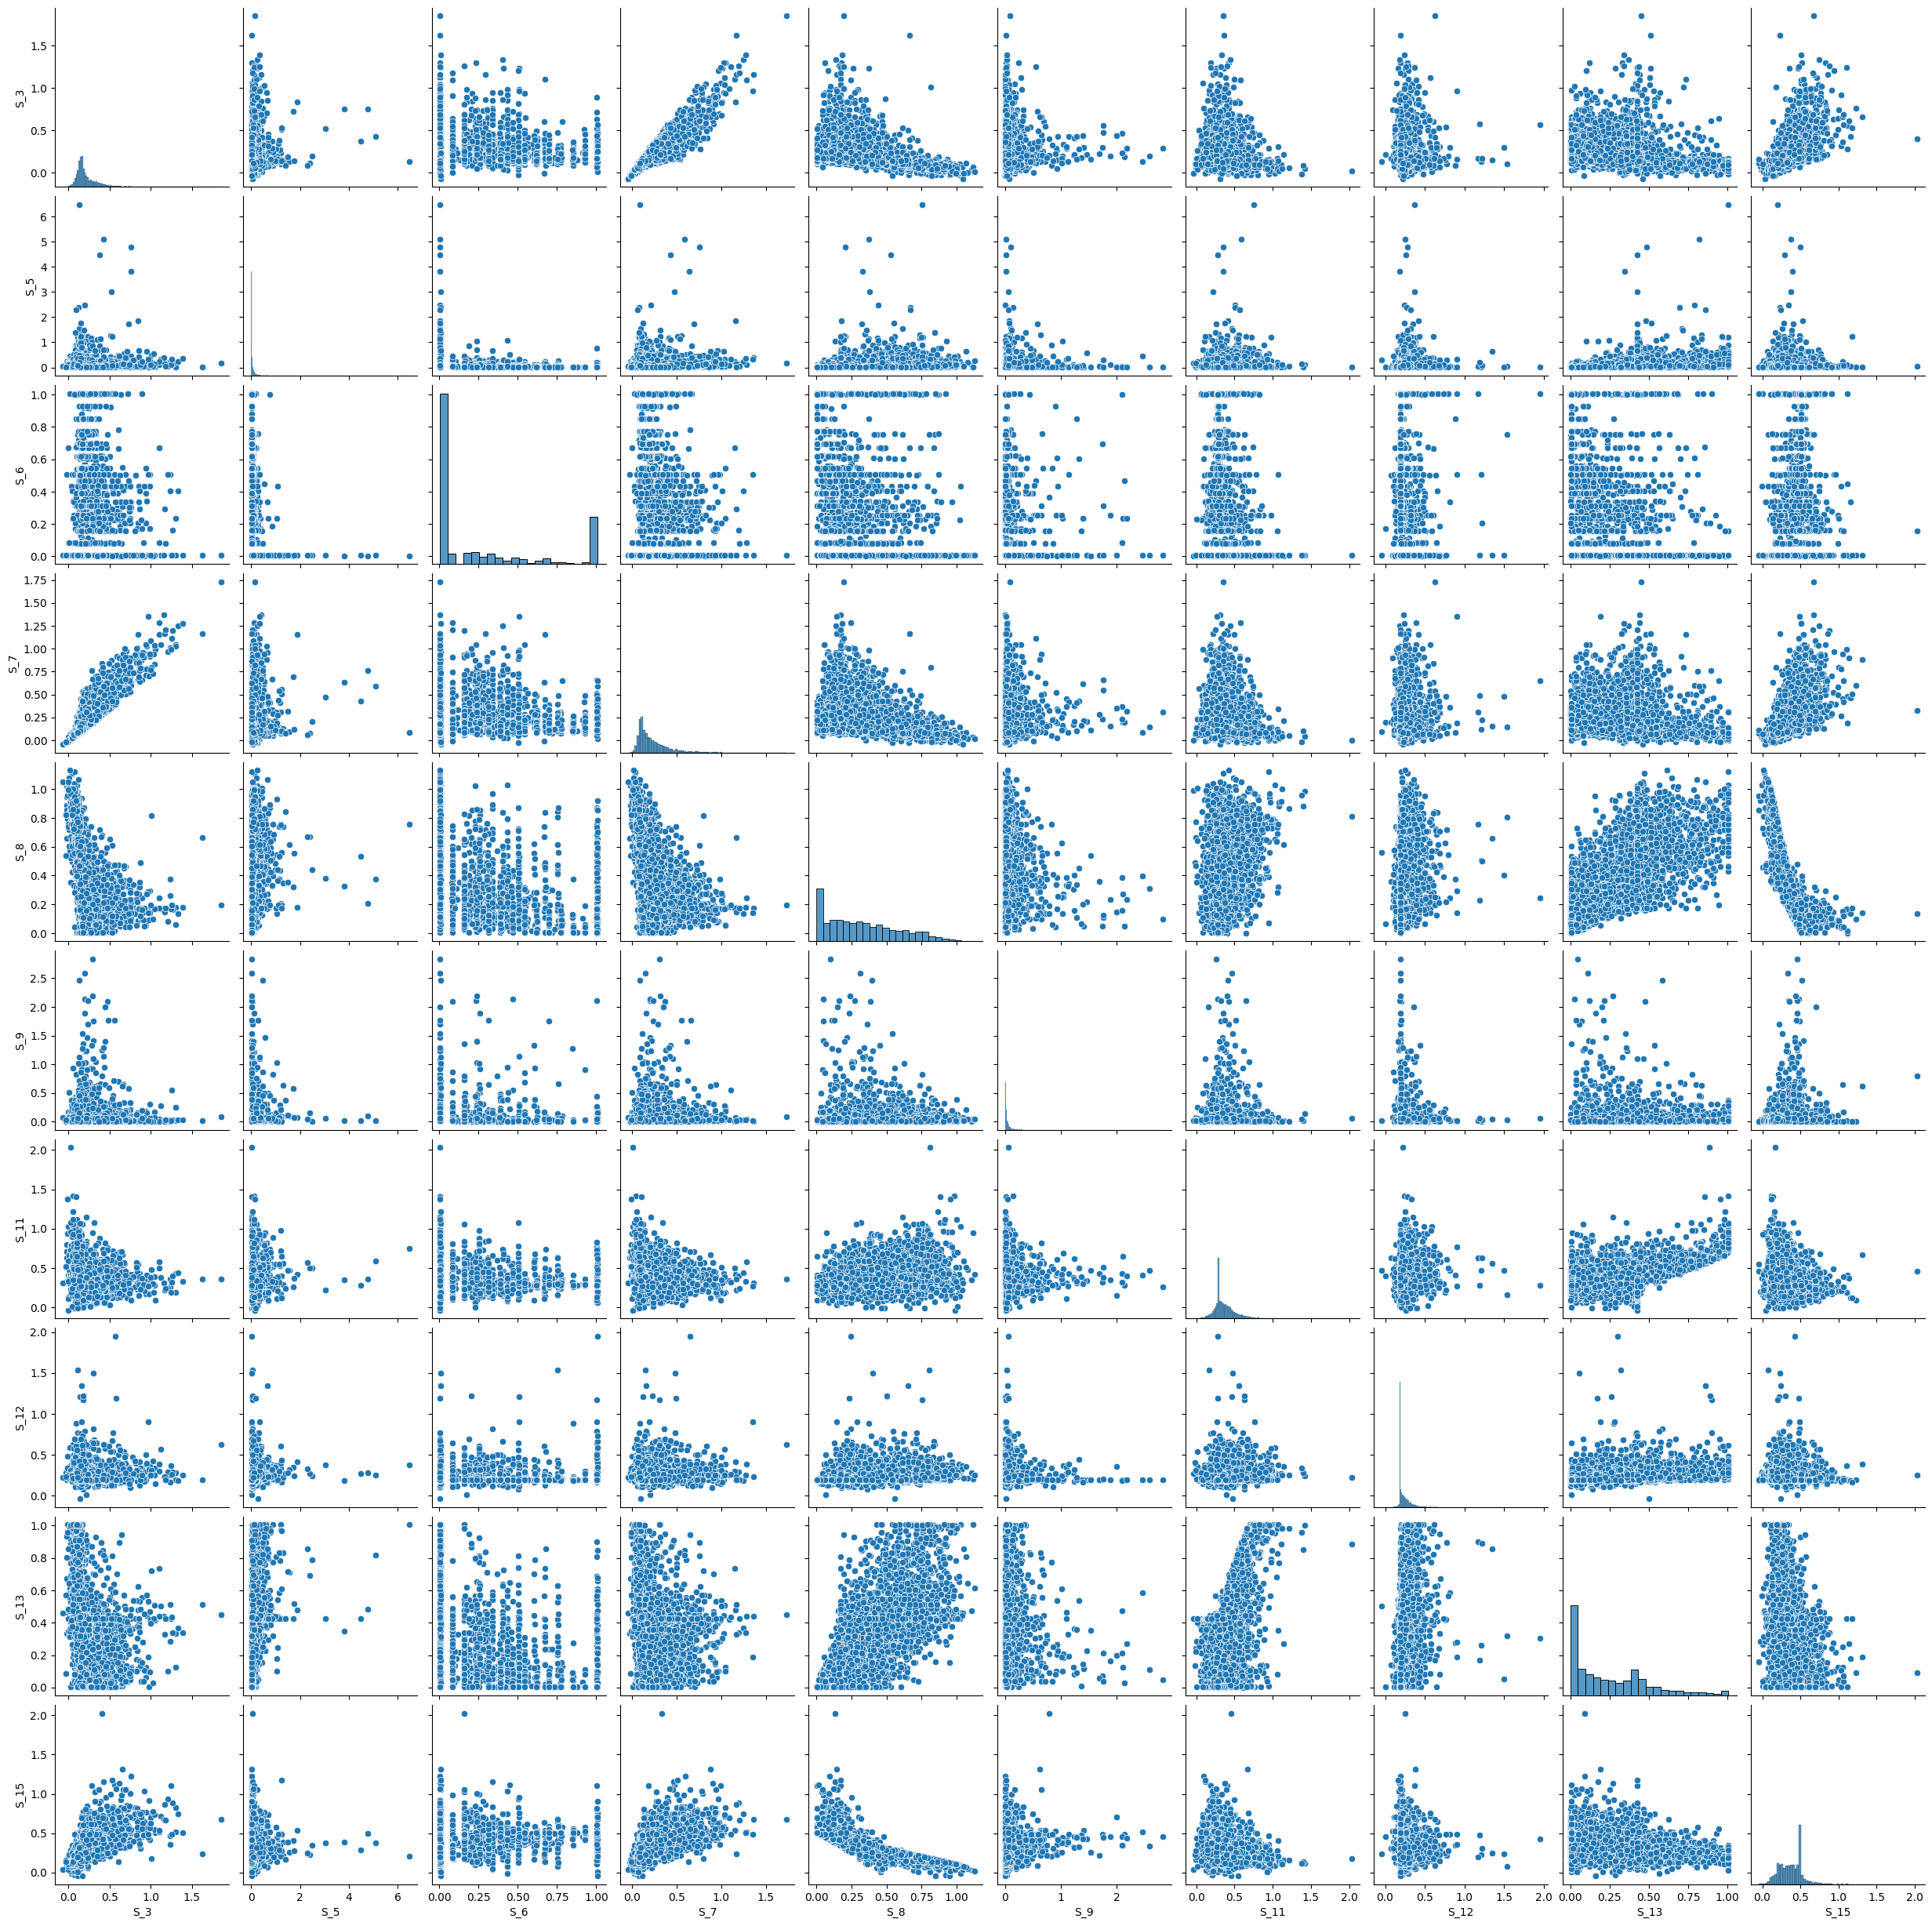

In [8]:
sns.pairplot(X_spend_avg.iloc[:,:10])

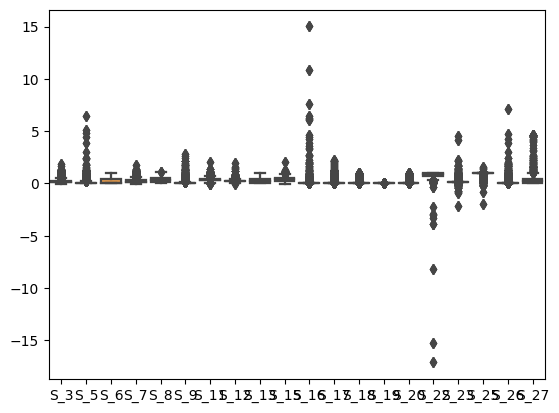

In [12]:
sns.boxplot(data=X_spend_avg)
plt.show()

In [16]:
X_spend_avg.isnull().mean()

S_3     0.120874
S_5     0.000000
S_6     0.000000
S_7     0.120874
S_8     0.000000
S_9     0.305355
S_11    0.000000
S_12    0.000000
S_13    0.000000
S_15    0.000000
S_16    0.000000
S_17    0.000000
S_18    0.000000
S_19    0.000000
S_20    0.000000
S_22    0.000219
S_23    0.000000
S_25    0.000000
S_26    0.000000
S_27    0.138579
dtype: float64

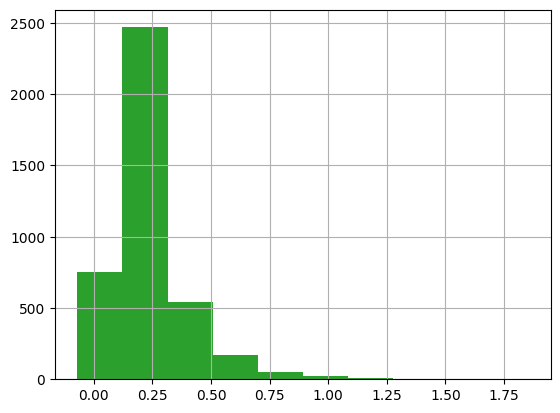

In [19]:
X_spend_avg['S_3'].hist()
plt.show()

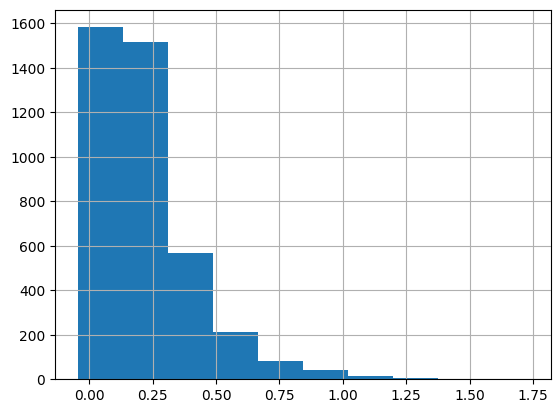

In [20]:
X_spend_avg['S_7'].hist()
plt.show()

## missing value

In [60]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(X_spend_avg) # Call the "fit" method on the object

X_spend_avg_imp = imputer.transform(X_spend_avg) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.17347635, 0.02541907, 0.0060533 , 0.16558696, 0.28969209,
       0.02339348, 0.33201694, 0.20369028, 0.18858314, 0.38084357,
       0.005054  , 0.00520849, 0.00502742, 0.0050297 , 0.00502875,
       0.93593993, 0.13601484, 0.97386458, 0.00592304, 0.26748921])

## scaling

In [61]:
from sklearn.preprocessing import RobustScaler

rs=RobustScaler()

X_spend_avg_scl=rs.fit_transform(X_spend_avg_imp)

In [62]:
X_spend_avg_df=pd.DataFrame(data=X_spend_avg_scl,columns=X_spend_avg.columns)

In [63]:
X_spend_avg_df.head()

S_3       S_5       S_6       S_7       S_8       S_9      S_11  \
0  0.245786  1.271113 -0.001813  2.323156  0.110506 -0.629427  0.657615   
1 -0.204826 -0.246710 -0.004851  1.739091  0.557792 -0.719625  0.422183   
2  0.011127 -0.151344 -0.002534  0.053758 -0.078971 -0.848922 -0.699986   
3  0.000000 -0.303312  2.327277  0.000000 -0.700529  0.000000 -0.288423   
4  0.839629 -0.271495  2.149261  0.893205 -0.646684  0.000000 -0.254816   

       S_12      S_13      S_15      S_16      S_17      S_18      S_19  \
0  1.772557  1.078018  0.065932  0.125721 -0.506803  0.432229 -0.920721   
1  0.965693 -0.154065 -0.749501  0.384092 -0.244840 -0.178597  0.043534   
2 -0.188928 -0.301354 -0.092021  1.571125 -0.682465 -0.087717 -0.029880   
3 -0.202086 -0.461154  0.513173  0.353091 -0.446836  0.737440 -0.316481   
4 -0.167204 -0.460919  0.416408  0.373808 -0.082531 -0.534028  0.630600   

       S_20      S_22        S_23        S_25       S_26      S_27  
0 -0.072953  0.112429  176.346603  -50.539379  66.670466  0.676162  
1 -1.169548 -0.514994   -0.182642    1.006599  -0.074729 -0.444893  
2  0.358053  0.058634   51.404096 -363.739361  -0.039214 -0.755383  
3  0.357115 -2.571770   -0.893154   -0.049355  -0.015347  0.000000  
4 -0.528394 -2.870445  915.149151    0.427583  -0.038246  0.000000

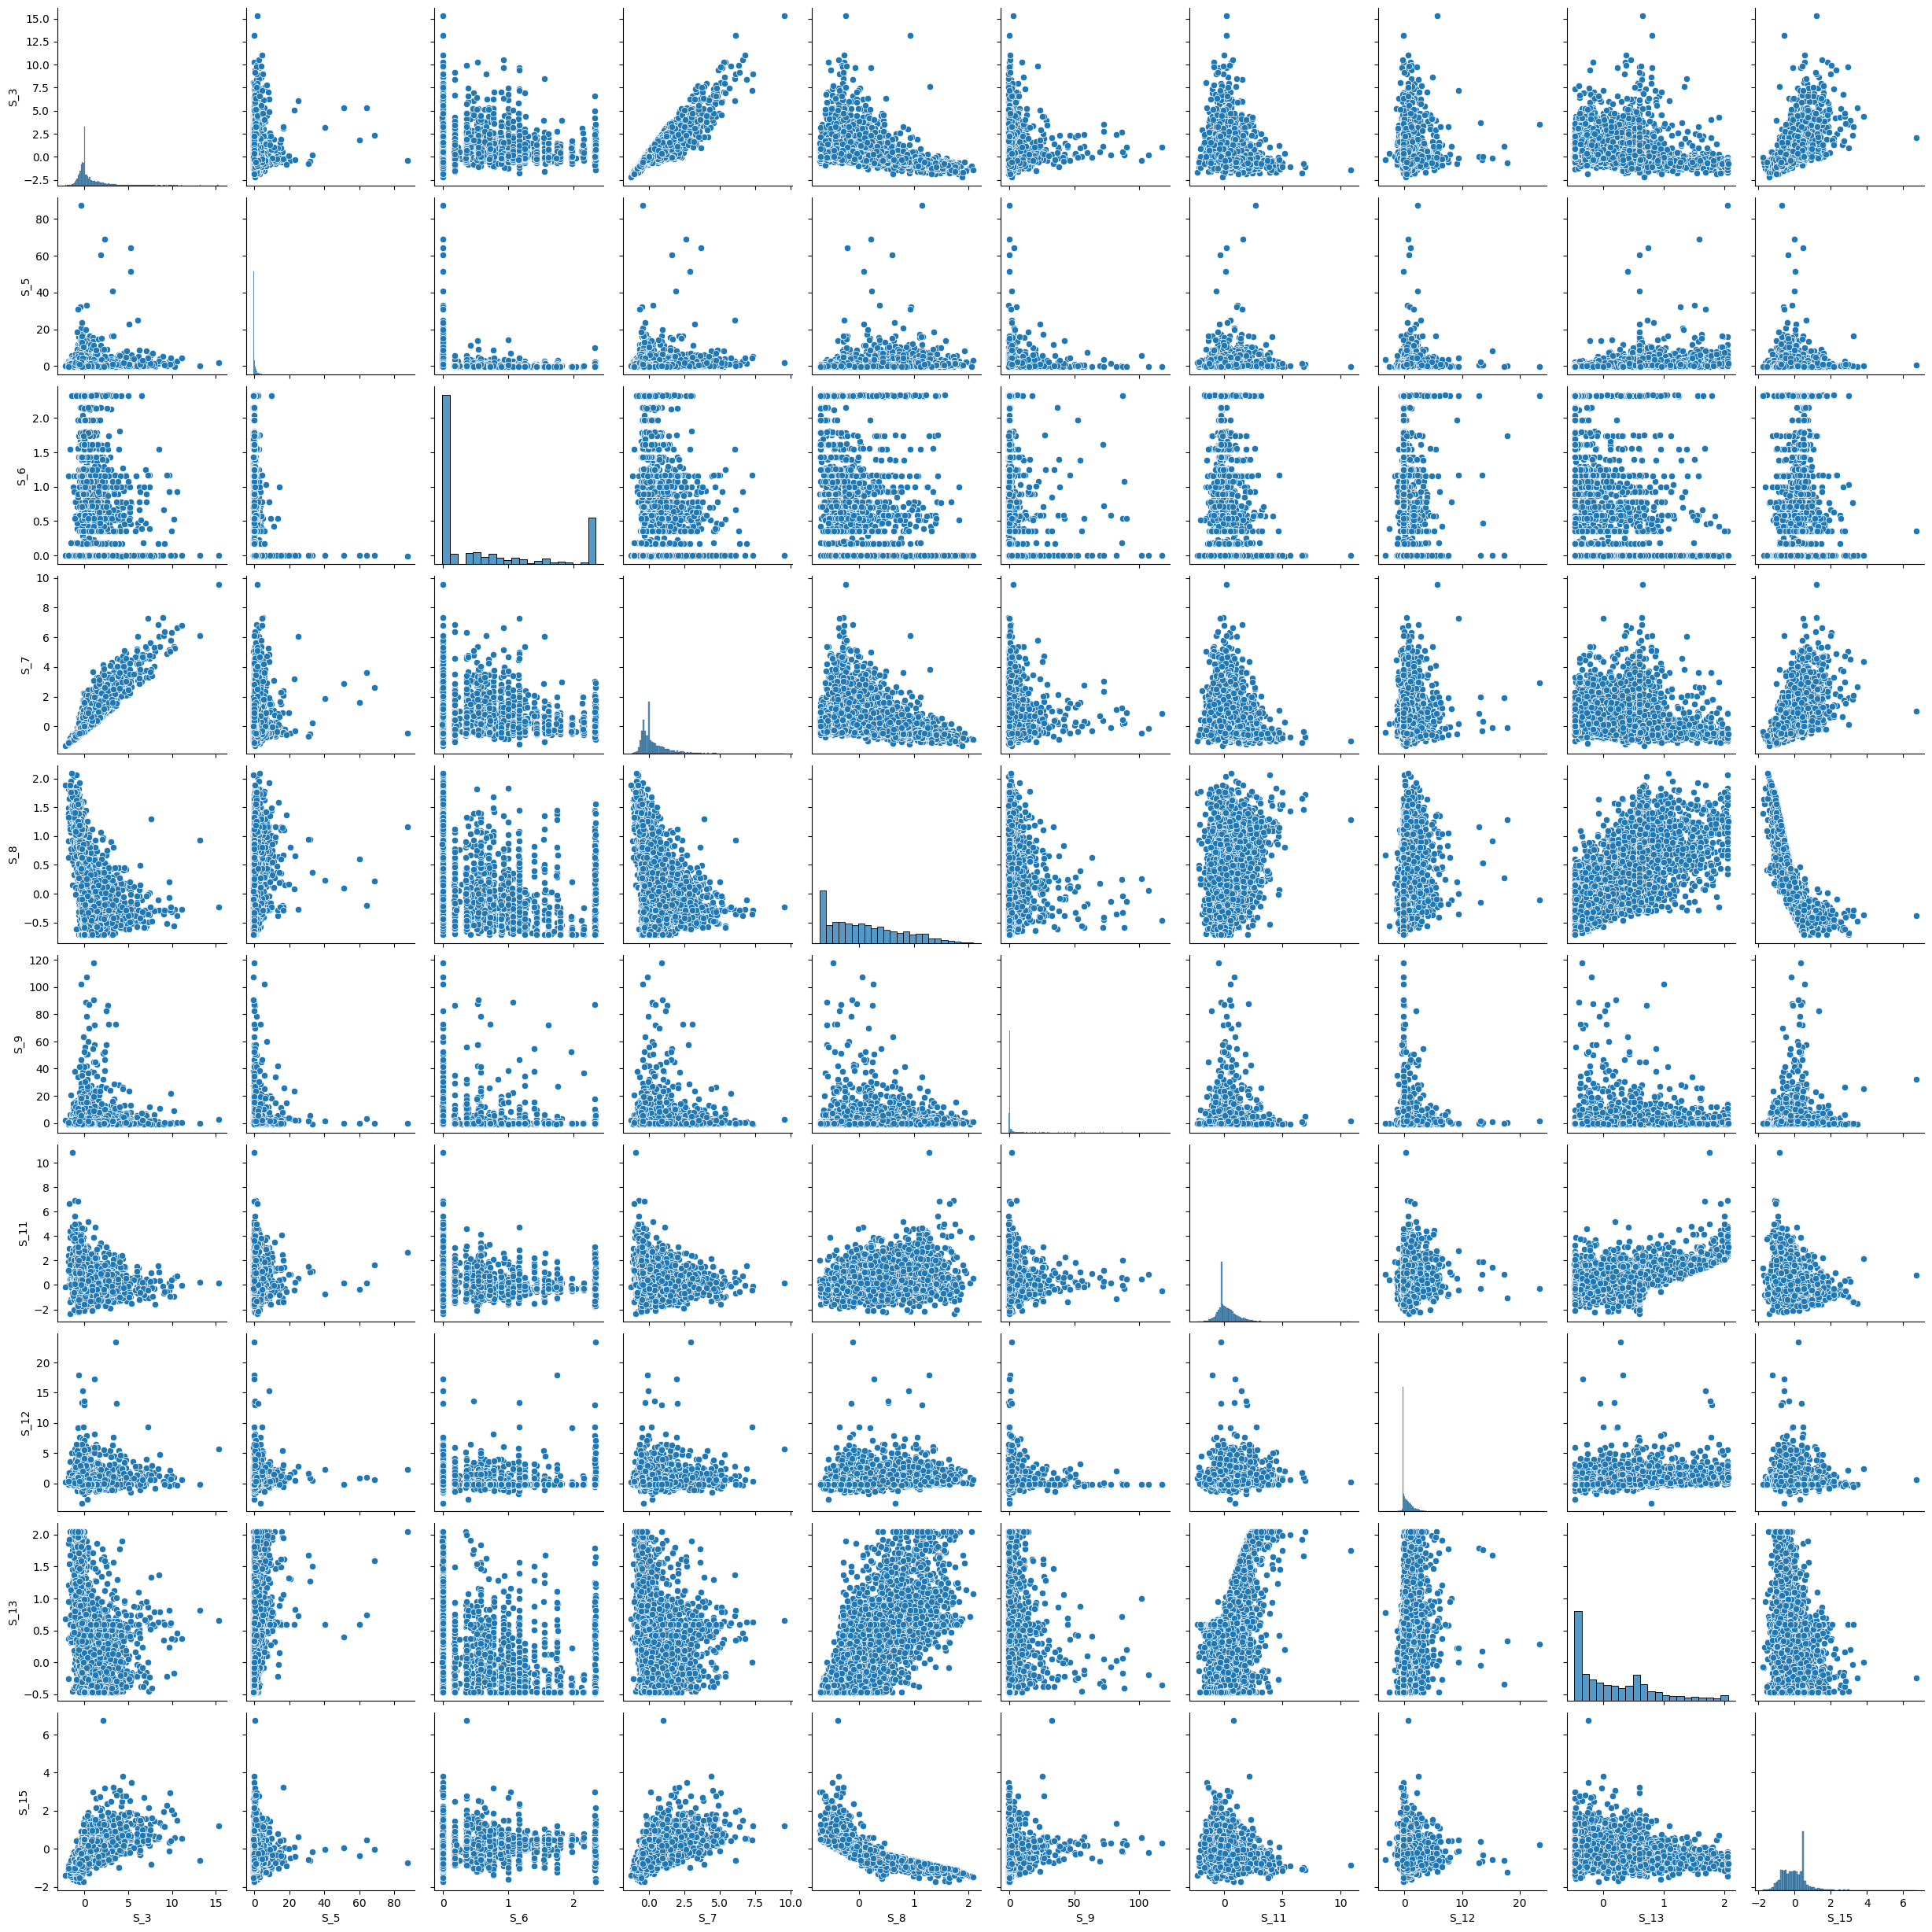

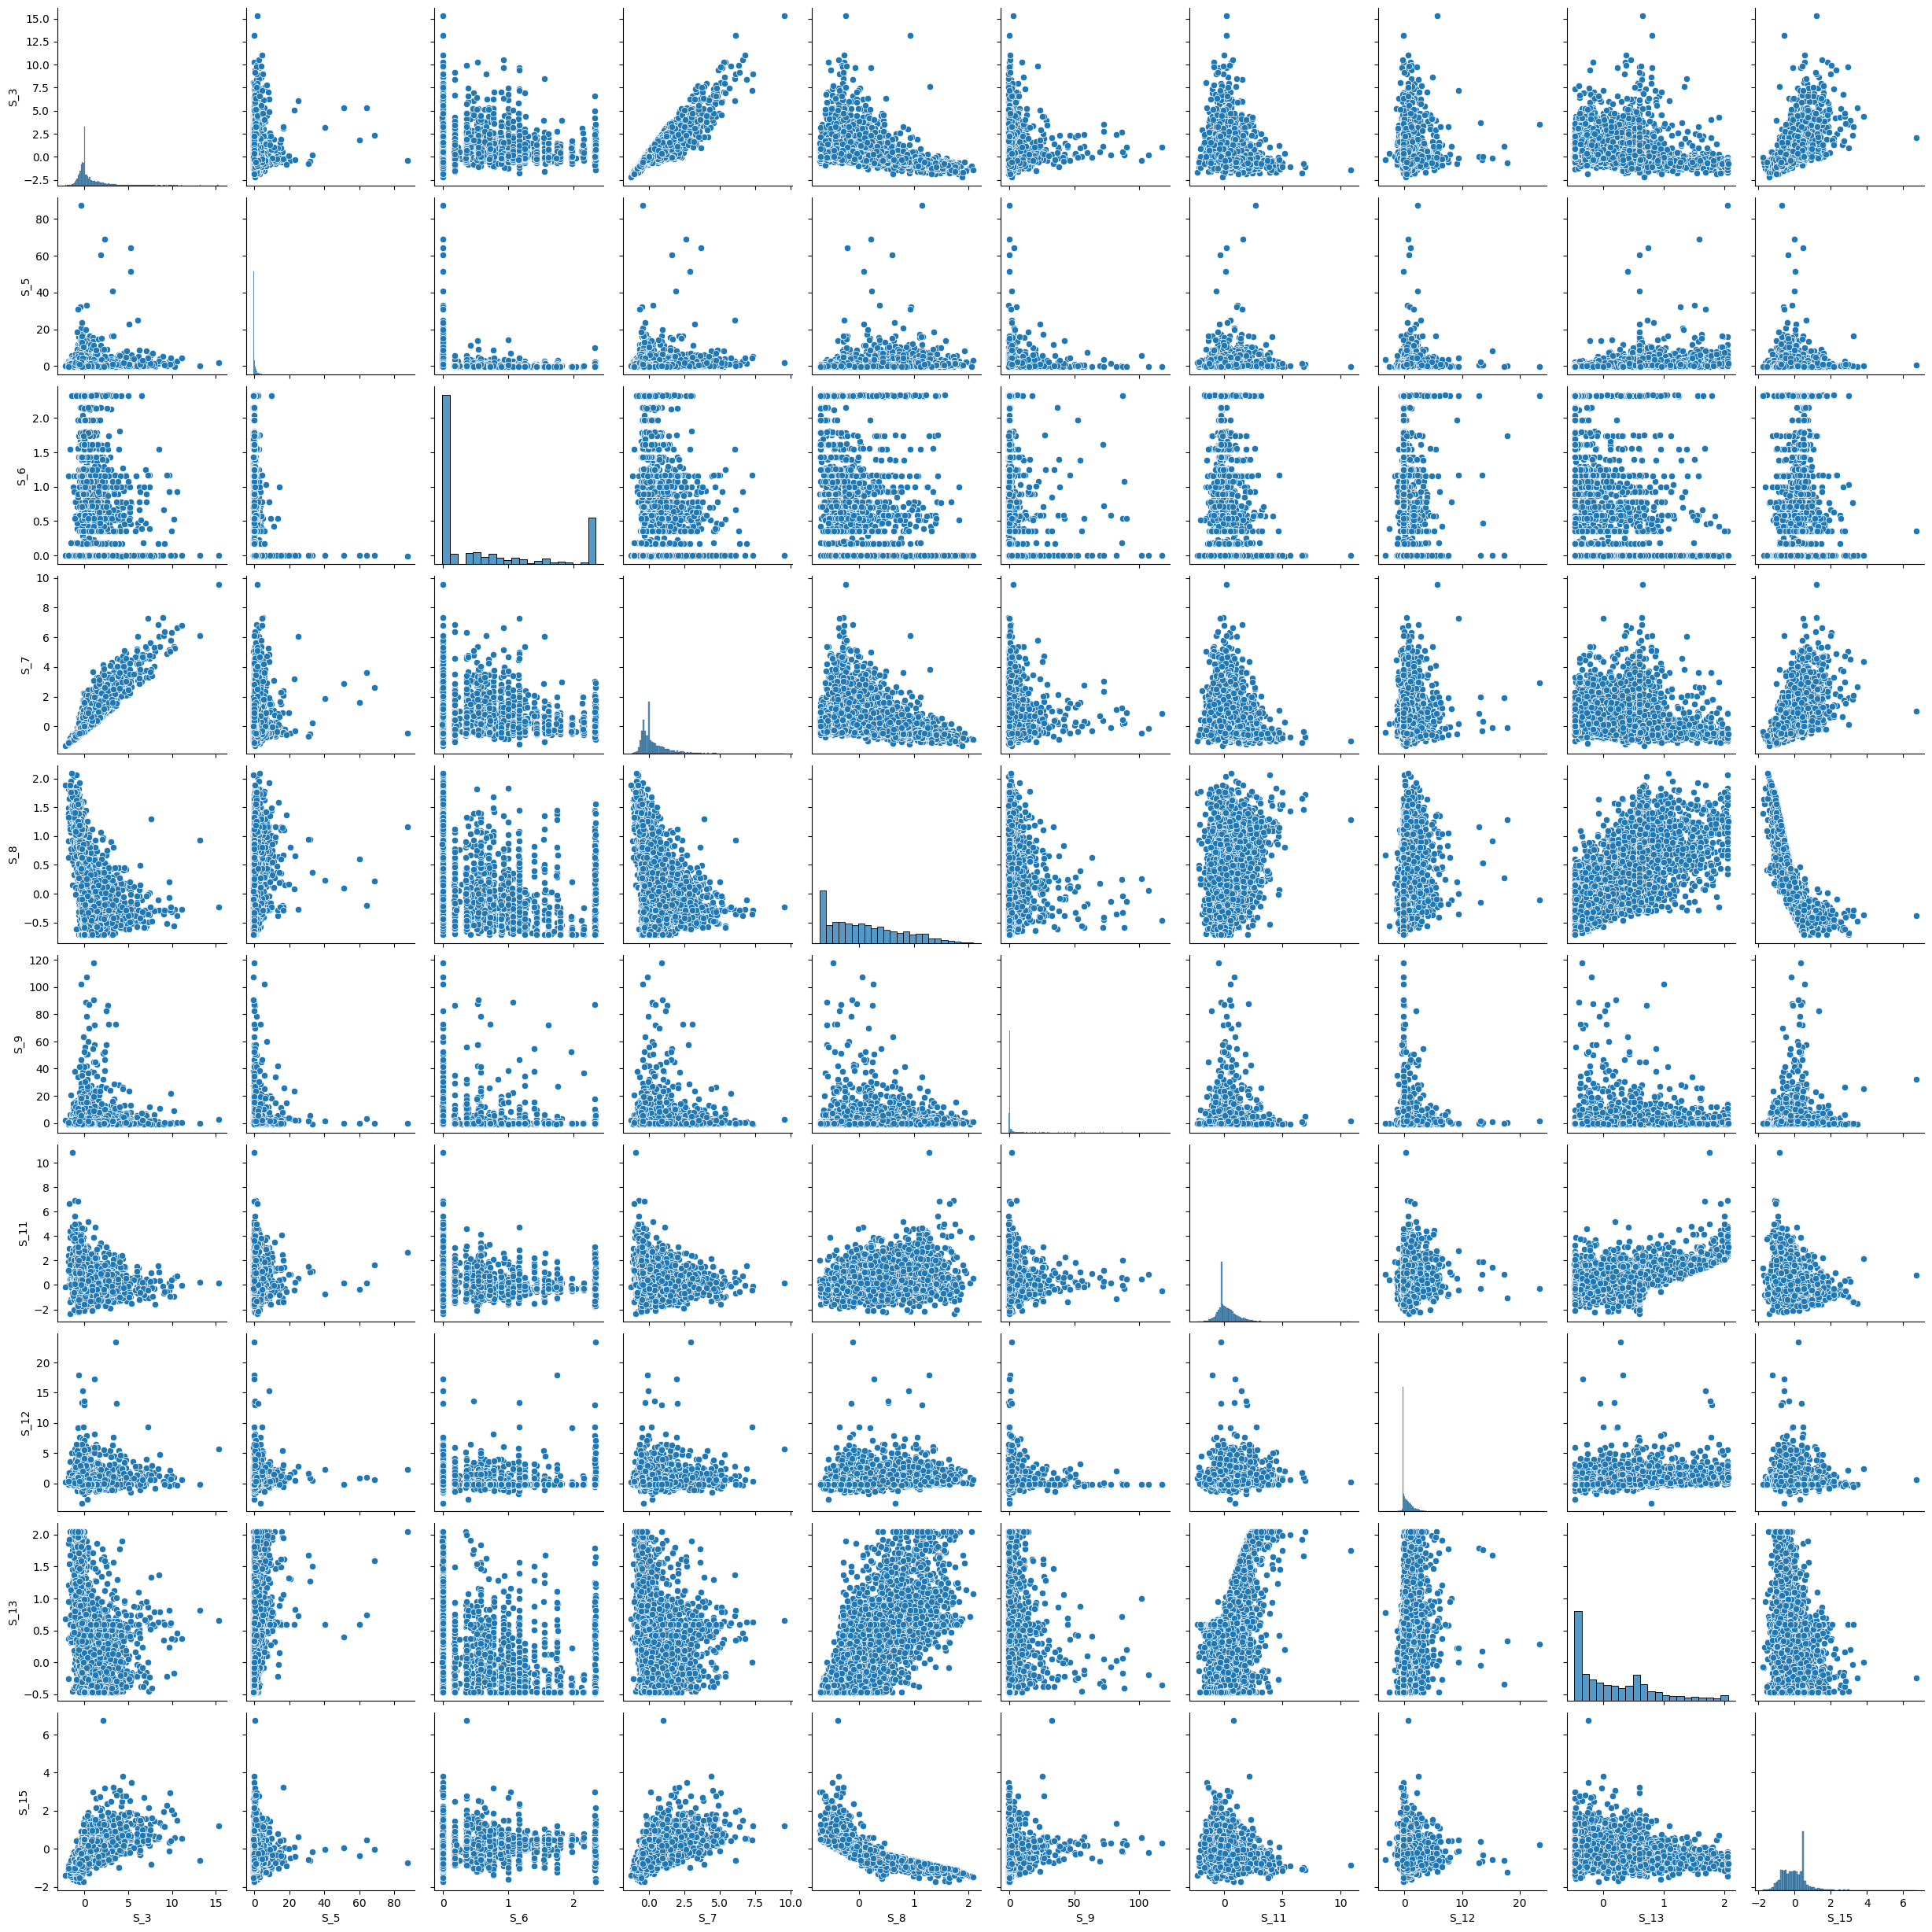

In [67]:
sns.pairplot(X_spend_avg_df.iloc[:,:10])
plt.show()

## PCA

In [99]:
from sklearn.decomposition import PCA

all_columns=X_spend_avg_df.columns

pca = PCA()
A=pca.fit_transform(X_spend_avg_df)

In [100]:
A

array([[-2.93079057e+01,  5.10015239e+01,  9.32878647e+01, ...,
         8.05479278e-01, -1.52728370e+00, -1.18329532e-01],
       [-3.16473952e+01, -3.52596752e+01, -2.39740265e+01, ...,
         1.76658997e-01, -1.53938425e+00,  1.86542940e-01],
       [-2.87788362e+01,  1.70434331e+01,  6.83322515e+01, ...,
         3.97372067e-02, -9.06537303e-02, -8.24691978e-02],
       ...,
       [-3.17489858e+01, -3.46782893e+01, -2.40782028e+01, ...,
         4.54879326e-01,  4.68150238e-01, -1.40663354e-01],
       [-2.93533150e+01,  6.26341205e+01,  1.17950787e+02, ...,
         1.26507519e-01, -5.52409840e-01, -3.11685584e-02],
       [-3.18973175e+01, -3.27816811e+01, -1.76162358e+01, ...,
         3.70148930e-01,  4.49555740e-01, -1.65373752e-02]])

In [69]:
# Access our 13 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=all_columns,
                 columns=[f'PC{i}' for i in range(1, len(all_columns)+1)])
W.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
S_3  0.001235  0.001477  0.002046  0.000553  0.001734 -0.001592 -0.024776   
S_5  0.000393  0.007266 -0.002091  0.000153 -0.000936 -0.000301  0.071586   
S_6 -0.000060 -0.001061 -0.000528  0.000382 -0.000980  0.000204 -0.015414   
S_7  0.000800  0.001087  0.001648  0.000394  0.001072 -0.001268 -0.015560   
S_8 -0.000030  0.000513 -0.000419 -0.000717 -0.000777  0.000144  0.020503   

          PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
S_3  0.009673  0.053384  0.074006  0.750677  0.004656 -0.151034  0.171255   
S_5  0.027822  0.980197  0.143273 -0.081114 -0.065609  0.000931 -0.011694   
S_6 -0.010151 -0.055535  0.216457  0.026484 -0.080043  0.172469 -0.318610   
S_7  0.007696  0.051714  0.028019  0.533130  0.046233 -0.146953  0.119106   
S_8  0.002927  0.034081 -0.158786 -0.146198  0.177633 -0.004519  0.195660   

         PC15      PC16      PC17      PC18      PC19      PC20  
S_3 -0.034676  0.047744 -0.076648 -0.349000  0.490111 -0.062519  
S_5 -0.002428 -0.033330  0.007733 -0.021283 -0.006170  0.006339  
S_6  0.119374 -0.689443 -0.555389  0.012797  0.102014  0.052379  
S_7 -0.034274  0.027616 -0.243662  0.369465 -0.688064  0.053291  
S_8 -0.041105  0.286459 -0.473321  0.026169  0.181315  0.735271

In [98]:
sum(W['PC1'].to_numpy()*X_spend_avg_df.iloc[0,:].to_numpy())

2.57654174093941

In [96]:
X_spend_avg_df.iloc[0,:]


S_3       0.245786
S_5       1.271113
S_6      -0.001813
S_7       2.323156
S_8       0.110506
S_9      -0.629427
S_11      0.657615
S_12      1.772557
S_13      1.078018
S_15      0.065932
S_16      0.125721
S_17     -0.506803
S_18      0.432229
S_19     -0.920721
S_20     -0.072953
S_22      0.112429
S_23    176.346603
S_25    -50.539379
S_26     66.670466
S_27      0.676162
Name: 0, dtype: float64

In [70]:
X_proj = pca.transform(X_spend_avg_df)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, len(all_columns)+1)])
X_proj.head()

PC1         PC2         PC3         PC4         PC5        PC6  \
0 -29.307906   51.001524   93.287865  115.498919  -13.851157  11.205373   
1 -31.647395  -35.259675  -23.974026    3.848992  -22.267787   4.811604   
2 -28.778836   17.043433   68.332251   87.949860  319.259020  31.690838   
3 -31.507231  -34.755909  -24.762112    3.655410  -20.949078   3.346964   
4 -19.444283  382.640684  546.022314  544.245640 -236.141414  23.922172   

         PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0  65.083141 -0.046772 -4.295896  0.857439  3.390555 -0.229691  0.165131   
1  -1.799101 -2.210484 -0.467758 -0.782730  0.207782  0.386295 -0.949646   
2   0.167660 -2.121979 -0.650211 -0.237062 -1.232383 -0.490208  0.231044   
3  -1.937422 -1.575600 -1.131766  2.239545 -0.195962 -0.493523  0.463917   
4  -1.398099 -3.046533 -3.320928  2.506787 -1.056107 -0.003746  0.921895   

       PC14      PC15      PC16      PC17      PC18      PC19      PC20  
0 -1.264927 -0.622228  0.454942 -0.026861  0.805479 -1.527284 -0.118330  
1  0.279658 -0.051926  0.640927 -0.504525  0.176659 -1.539384  0.186543  
2 -0.322450 -0.022888  0.612964 -0.008833  0.039737 -0.090654 -0.082469  
3 -0.750389 -0.079169 -0.878921 -0.194559  0.057387 -0.025076 -0.003317  
4 -0.642473  0.797113 -0.441814 -0.542975 -0.003448 -0.182041 -0.069858

In [71]:
# Let's compute it
var=X_proj.std()**2 / ((df.std()**2).sum())

var

/var/folders/7w/9f2_d9m51s93m3qp55wpl5ym0000gn/T/ipykernel_59494/3992524632.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var=X_proj.std()**2 / ((df.std()**2).sum())


PC1     1442.581504
PC2      160.449313
PC3      147.740892
PC4      135.683703
PC5       74.657460
PC6       39.837563
PC7        0.858187
PC8        0.619350
PC9        0.114489
PC10       0.050987
PC11       0.037233
PC12       0.021280
PC13       0.016328
PC14       0.012014
PC15       0.010236
PC16       0.007250
PC17       0.002761
PC18       0.001642
PC19       0.001394
PC20       0.000330
dtype: float64

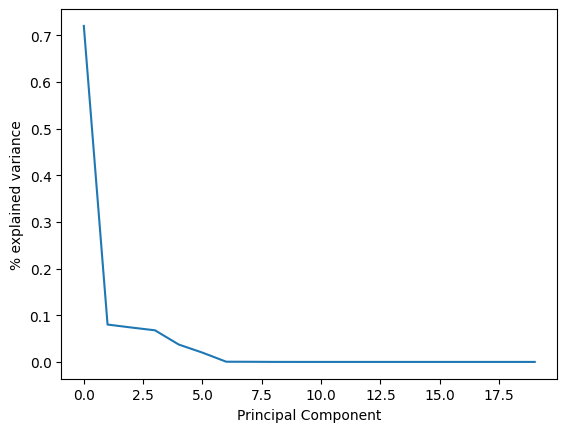

In [72]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');
plt.show()

In [73]:
X_proj.shape

(4575, 20)

In [83]:
X_proj.head()

PC1         PC2         PC3         PC4         PC5        PC6  \
0 -29.307906   51.001524   93.287865  115.498919  -13.851157  11.205373   
1 -31.647395  -35.259675  -23.974026    3.848992  -22.267787   4.811604   
2 -28.778836   17.043433   68.332251   87.949860  319.259020  31.690838   
3 -31.507231  -34.755909  -24.762112    3.655410  -20.949078   3.346964   
4 -19.444283  382.640684  546.022314  544.245640 -236.141414  23.922172   

         PC7       PC8       PC9      PC10  ...      PC12      PC13      PC14  \
0  65.083141 -0.046772 -4.295896  0.857439  ... -0.229691  0.165131 -1.264927   
1  -1.799101 -2.210484 -0.467758 -0.782730  ...  0.386295 -0.949646  0.279658   
2   0.167660 -2.121979 -0.650211 -0.237062  ... -0.490208  0.231044 -0.322450   
3  -1.937422 -1.575600 -1.131766  2.239545  ... -0.493523  0.463917 -0.750389   
4  -1.398099 -3.046533 -3.320928  2.506787  ... -0.003746  0.921895 -0.642473   

       PC15      PC16      PC17      PC18      PC19      PC20  default  
0 -0.622228  0.454942 -0.026861  0.805479 -1.527284 -0.118330      NaN  
1 -0.051926  0.640927 -0.504525  0.176659 -1.539384  0.186543      NaN  
2 -0.022888  0.612964 -0.008833  0.039737 -0.090654 -0.082469      NaN  
3 -0.079169 -0.878921 -0.194559  0.057387 -0.025076 -0.003317      NaN  
4  0.797113 -0.441814 -0.542975 -0.003448 -0.182041 -0.069858      NaN  

[5 rows x 21 columns]

In [81]:
y_avg.head()

customer_ID
000919ba92d9a04c28e1e49f6cd855ca36e1df7c79cc0583b60734da25265fb1    0.0
00158cf08fcf7ec058529dd71b4cff04ce89314e79840b76a183afa0ae941c34    0.0
0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f166dc2f2158513462    1.0
0044d8693a5c204d5e22297b11e566d9de1c1610899d20f46abff9a163f78b3e    0.0
00597bc3d552264d841bd1a52cfaf3ebe40755f96d85a5282695654cee8af21f    1.0
Name: default, dtype: float64

In [82]:
y_avg.shape

(4575,)

In [84]:
X_proj['default']=y_avg.to_numpy()

In [86]:
X_proj[['PC1','PC2','default']].head()

PC1         PC2  default
0 -29.307906   51.001524      0.0
1 -31.647395  -35.259675      0.0
2 -28.778836   17.043433      1.0
3 -31.507231  -34.755909      0.0
4 -19.444283  382.640684      1.0

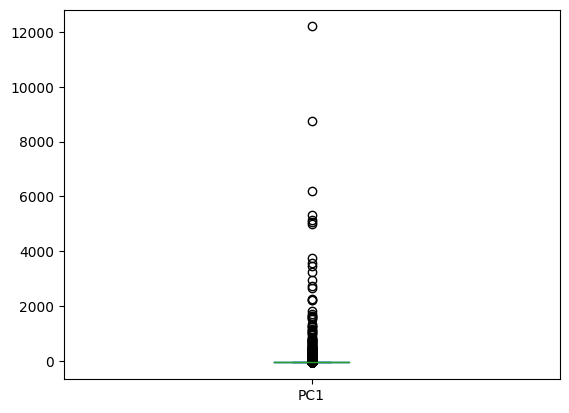

In [94]:
X_proj['PC1'].plot(kind='box')
plt.show()

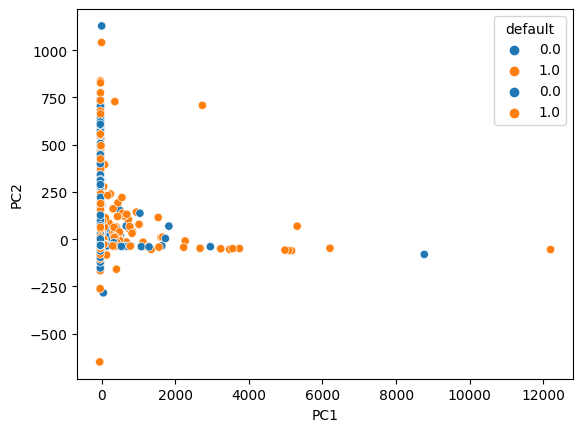

In [88]:
sns.scatterplot(data=X_proj[['PC1','PC2','default']],x='PC1',y='PC2',hue='default')
plt.show()

## KNN clustering

In [ ]:
from sklearn.cluster import KMeans

# Fit K-means
km = KMeans(n_clusters=2)
km.fit(X_proj)

In [ ]:
sns.barplot(data=df.drop(columns=['S_2','customer_ID']),x='default',y='S_3')

In [ ]:
defaulter_spend_df.head()

In [ ]:
cus1=defaulter_spend_df[defaulter_spend_df['customer_ID']=='0018753794d55ff4ab24aaa7f8e65d504fd1efbf04e369f166dc2f2158513462']

spend_vals.remove('S_2')
spend_vals.remove('customer_ID')

cus1.plot('S_2',spend_vals)

In [ ]:
cus1.plot('S_2','S_9',kind='scatter')

In [ ]:
cus1.isnull().groupby('customer_ID').mean()

In [ ]:
defaulter_miss=pd.concat([defaulter_spend_df[['customer_ID']],defaulter_spend_df.iloc[:,1:].isnull()],axis=1).\
groupby('customer_ID').mean()

In [ ]:
defaulter_miss

In [ ]:
(defaulter_miss>0.8).any(axis=1).mean()

In [ ]:
defaulter_spend_df.iloc[:,1:].isnull().mean()

## Missing values

In [ ]:
defaulter_spend_df['target']=1
payer_spend_df['target']=0

spend=pd.concat([defaulter_spend_df,payer_spend_df],axis=0)

In [ ]:
spend.head()

In [ ]:
spend_ave=spend.drop(columns=['S_2']).groupby('customer_ID').mean()

In [ ]:
spend_ave.head()

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean") # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(spend_ave) # Call the "fit" method on the object

spend_ave_array = imputer.transform(spend_ave) # Call the "transform" method on the object


In [ ]:
spend_ave_array_df=pd.DataFrame(data=spend_ave_array,columns=spend_ave.columns).reset_index()

In [ ]:
spend_ave_array_df.head()

## PCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

defaulter=pd.read_csv('defaulter_data_13364.csv')
defaulter['target']=1

payer=pd.read_csv('payer_data_41940.csv')
payer['target']=0

In [ ]:
df=pd.concat([defaulter,payer])


In [ ]:
df.head()

In [ ]:
df=df.drop(columns=['Unnamed: 0','S_2','customer_ID','target'])

df=df.fillna(method='bfill').fillna(method='ffill')

In [ ]:
df.head()

In [ ]:
df=df.drop(columns=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])

In [ ]:
from sklearn.decomposition import PCA

all_columns=df.columns

pca = PCA()
pca.fit(df)

In [ ]:
# Access our 13 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=all_columns,
                 columns=[f'PC{i}' for i in range(1, len(all_columns)+1)])
W

In [ ]:
X_proj = pca.transform(df)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, len(all_columns)+1)])
X_proj

In [ ]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');

In [ ]:
# Let's compute it
var=X_proj.std()**2 / ((df.std()**2).sum())

In [ ]:
var

In [ ]:
var[:8].sum()/var.sum()

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance')

## Conclusions

1. PCA redistributes the ratio among the new features in the most unequal way
2. top 4 pcs explains about 76% of the variance
